In [36]:
import pandas as pd
import math
import random
import matplotlib.pyplot as plt

class StockOracle:
    """
    A class to simulate a stock's price using various stochastic processes.

    The simulation can be configured to model:
    - A pump-and-dump event with post-dump recovery.
    - A pure mean-reverting process (Ornstein-Uhlenbeck).
    - A trending process (random walk with drift).
    """
    def __init__(self, start_date, end_date, periods=365, x0=100, kappa=0.5, theta=100, sigma=0.5,
                 pump_start_percent=0.4, pump_end_percent=0.6, dump_end_percent=0.7,
                 post_dump_drift_strength=0.1, simulation_type="pump_and_dump", trend_drift=0.5):
        """
        Initializes the StockOracle with simulation parameters.

        Args:
            start_date (str): The start date for the simulation (e.g., '2023-01-01').
            end_date (str): The end date for the simulation (e.g., '2024-01-01').
            periods (int): The number of periods to simulate.
            x0 (float): The initial price of the stock.
            kappa (float): The rate of mean reversion.
            theta (float): The long-term mean of the process.
            sigma (float): The volatility of the process.
            pump_start_percent (float): The percentage of the period when the pump starts (0.0 to 1.0).
            pump_end_percent (float): The percentage of the period when the pump ends.
            dump_end_percent (float): The percentage of the period when the dump ends.
            post_dump_drift_strength (float): Strength of the negative drift after the dump.
            simulation_type (str): The type of simulation to run ("pump_and_dump", "mean_reverting", or "trend").
            trend_drift (float): The constant drift for the "trend" simulation.
        """
        self.start = start_date
        self.end = end_date
        self.periods = periods
        self.x0 = x0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.pump_start_percent = pump_start_percent
        self.pump_end_percent = pump_end_percent
        self.dump_end_percent = dump_end_percent
        self.post_dump_drift_strength = post_dump_drift_strength
        self.simulation_type = simulation_type
        self.trend_drift = trend_drift

        if self.simulation_type == "pump_and_dump":
            self.price_history = self._simulate_pump_dump_data()
        elif self.simulation_type == "mean_reverting":
            self.price_history = self._simulate_mean_reverting_data()
        elif self.simulation_type == "trend":
            self.price_history = self._simulate_trend_data()
        else:
            raise ValueError("Invalid simulation_type provided. Choose from 'pump_and_dump', 'mean_reverting', or 'trend'.")

    def _simulate_pump_dump_data(self):
        """
        Simulates the stock price data with pump-and-dump logic and post-dump behavior.
        """
        index = pd.date_range(start=self.start, end=self.end, periods=self.periods)

        # Determine the periods for each phase
        total_periods = len(index)
        pump_start_idx = int(total_periods * self.pump_start_percent)
        pump_end_idx = int(total_periods * self.pump_end_percent)
        dump_end_idx = int(total_periods * self.dump_end_percent)

        # Initialize price list with the starting price
        s = [self.x0]
        dt = (index[-1] - index[0]).days / 365 / total_periods

        # Loop through each time period to simulate the price
        for t in range(1, total_periods):
            s_t_minus_1 = s[t - 1]

            # Base stochastic process (Ornstein-Uhlenbeck)
            drift = self.kappa * (self.theta - s_t_minus_1) * dt
            volatility = s_t_minus_1 * self.sigma * math.sqrt(dt) * random.gauss(0, 1)

            # --- Pump-and-Dump and Post-Dump Logic ---
            additional_drift = 0
            if pump_start_idx <= t < pump_end_idx:
                # Add a strong positive drift for the "pump" period
                additional_drift = 2.0 * dt * self.x0  # A strong positive constant drift
            elif pump_end_idx <= t < dump_end_idx:
                # Add a very strong negative drift for the "dump" period
                additional_drift = -5.0 * dt * self.x0 # An even stronger negative drift
            elif t >= dump_end_idx:
                # Gradual decrease towards initial price after the dump
                additional_drift = -self.post_dump_drift_strength * (s_t_minus_1 - self.x0) * dt

            # Calculate the new price
            s_t = (s_t_minus_1 + drift + volatility + additional_drift)
            s.append(max(0, s_t)) # Price cannot go below zero

        return pd.Series(s, index=index)

    def _simulate_mean_reverting_data(self):
        """
        Simulates the stock price using a pure mean-reverting (Ornstein-Uhlenbeck) process.
        """
        index = pd.date_range(start=self.start, end=self.end, periods=self.periods)
        s = [self.x0]
        dt = (index[-1] - index[0]).days / 365 / len(index)
        for t in range(1, len(index)):
            s_t_minus_1 = s[t - 1]
            drift = self.kappa * (self.theta - s_t_minus_1) * dt
            volatility = s_t_minus_1 * self.sigma * math.sqrt(dt) * random.gauss(0, 1)
            s_t = (s_t_minus_1 + drift + volatility)
            s.append(max(0, s_t))
        return pd.Series(s, index=index)

    def _simulate_trend_data(self):
        """
        Simulates the stock price using a random walk with a constant drift.
        The trend is determined by the sign of the 'trend_drift' parameter.
        """
        index = pd.date_range(start=self.start, end=self.end, periods=self.periods)
        s = [self.x0]
        dt = (index[-1] - index[0]).days / 365 / len(index)
        for t in range(1, len(index)):
            s_t_minus_1 = s[t - 1]
            # A constant drift is added to the random walk
            drift = self.trend_drift * dt * self.x0
            volatility = s_t_minus_1 * self.sigma * math.sqrt(dt) * random.gauss(0, 1)
            s_t = (s_t_minus_1 + drift + volatility)
            s.append(max(0, s_t))
        return pd.Series(s, index=index)

    def get_price_at_date(self, date):
        """
        Returns the simulated stock price for a given date.

        Args:
            date (str or pandas.Timestamp): The date to query.

        Returns:
            float: The simulated price, or None if the date is outside the range.
        """
        try:
            return self.price_history.loc[date]
        except KeyError:
            print(f"Date {date} is outside the simulation range.")
            return None

    def mean_reverting_price(self):
        """
        Returns the mean-reverting price of the stock.

        Returns:
            float: The long-term mean price (theta).
        """
        return self.theta

    def price_trend(self, days):
        """
        Determines the price trend (up or down) over a given number of days.

        Args:
            days (int): The number of days to look back for the trend.

        Returns:
            str: "Upward Trend", "Downward Trend", or "Insufficient Data".
        """
        if days >= len(self.price_history):
            return "Insufficient Data"

        start_price = self.price_history.iloc[-days-1]
        end_price = self.price_history.iloc[-1]

        if end_price > start_price:
            return "Upward Trend"
        elif end_price < start_price:
            return "Downward Trend"
        else:
            return "No Change"




--- Simulating Pump-and-Dump ---


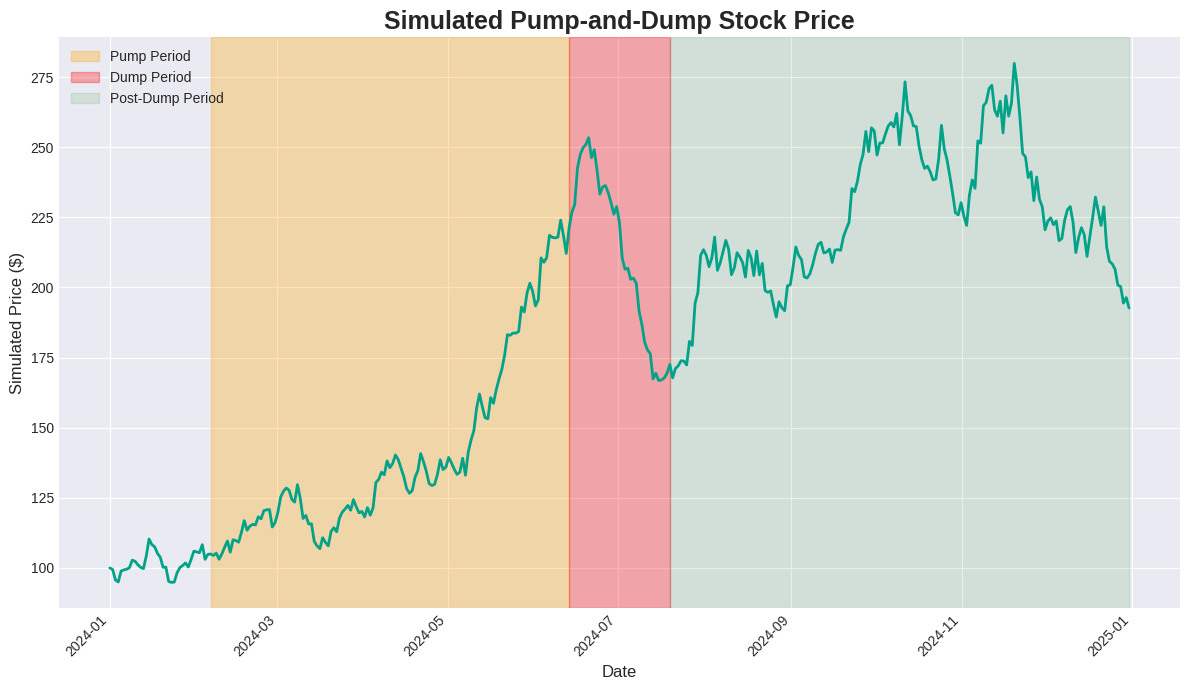


--- Simulating Mean-Reverting Process ---


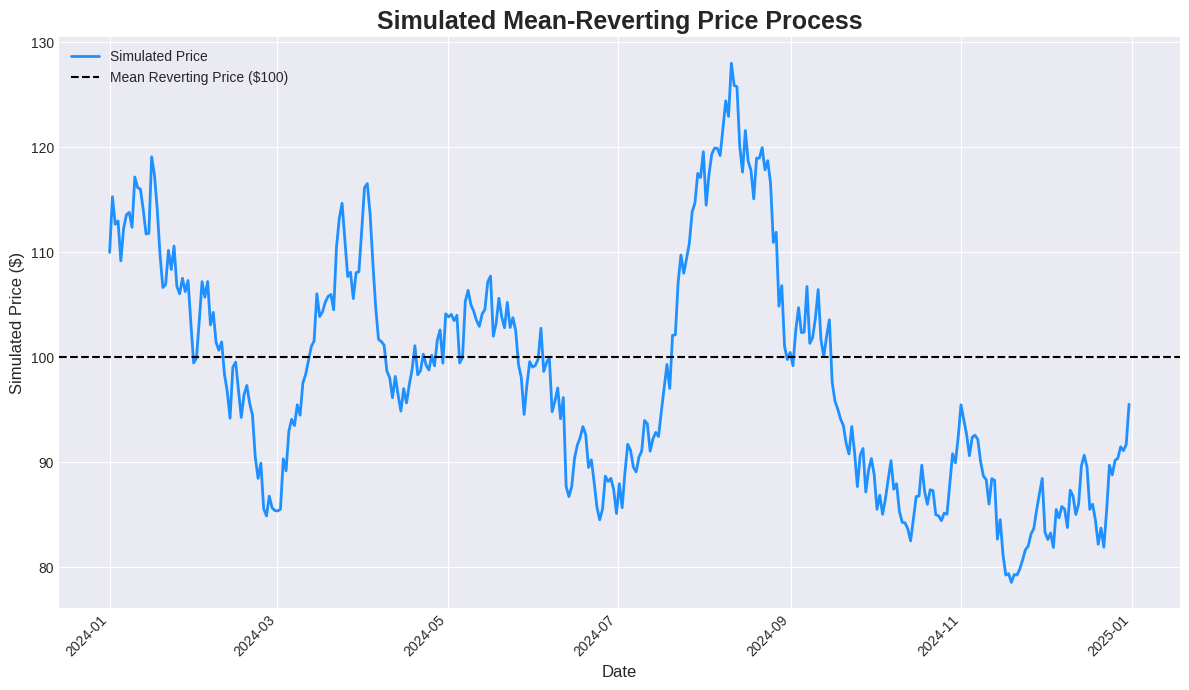


--- Simulating Trending Process (Upward Trend) ---
Current trend over the last 30 days: Upward Trend


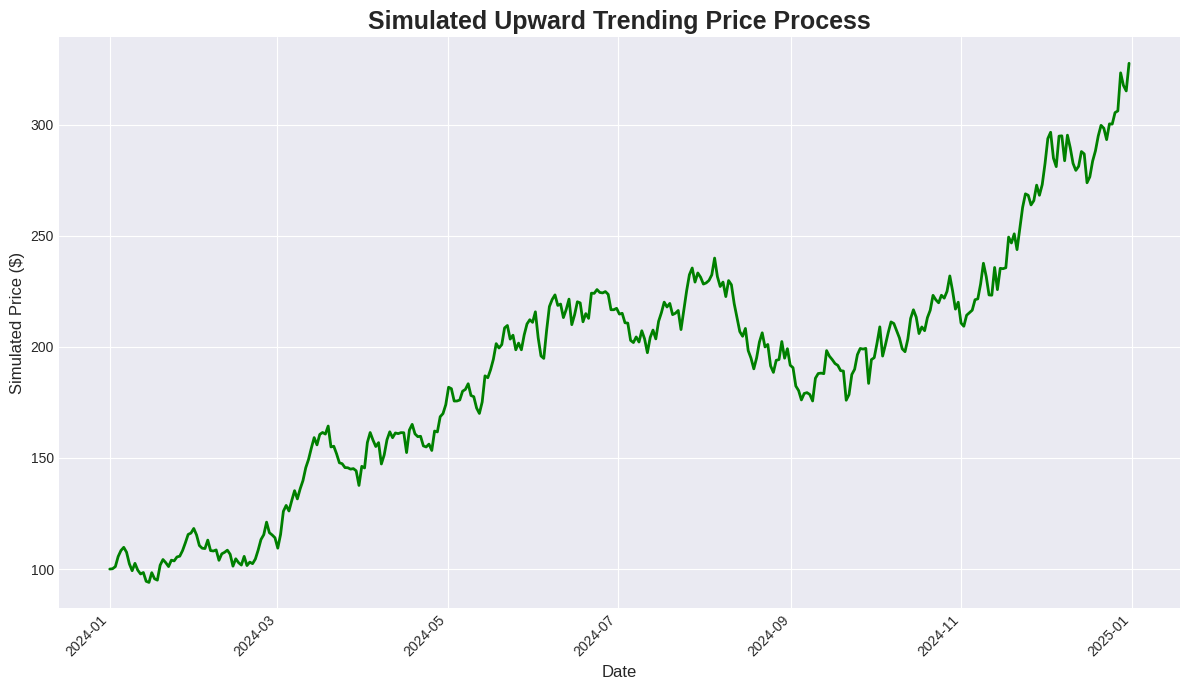

In [38]:
# --- Example 1: Pump-and-Dump Simulation ---
print("--- Simulating Pump-and-Dump ---")
oracle_pump_dump = StockOracle(
    start_date='2024-01-01',
    end_date='2024-12-31',
    periods=365,
    x0=100,
    simulation_type="pump_and_dump",
    pump_start_percent=0.1,
    pump_end_percent=0.45,
    dump_end_percent=0.55
)
price_data_pump_dump = oracle_pump_dump.price_history

# Plotting the results
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(price_data_pump_dump.index, price_data_pump_dump.values, color='#00A388', linewidth=2)

total_periods = len(price_data_pump_dump)
pump_start_idx = int(total_periods * oracle_pump_dump.pump_start_percent)
pump_end_idx = int(total_periods * oracle_pump_dump.pump_end_percent)
dump_end_idx = int(total_periods * oracle_pump_dump.dump_end_percent)
ax.axvspan(price_data_pump_dump.index[pump_start_idx], price_data_pump_dump.index[pump_end_idx], color='orange', alpha=0.3, label='Pump Period')
ax.axvspan(price_data_pump_dump.index[pump_end_idx], price_data_pump_dump.index[dump_end_idx], color='red', alpha=0.3, label='Dump Period')
ax.axvspan(price_data_pump_dump.index[dump_end_idx], price_data_pump_dump.index[-1], color='green', alpha=0.1, label='Post-Dump Period')
ax.set_title('Simulated Pump-and-Dump Stock Price', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Simulated Price ($)', fontsize=12)
ax.legend(loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Example 2: Mean-Reverting Simulation ---
print("\n--- Simulating Mean-Reverting Process ---")
oracle_mr = StockOracle(
    start_date='2024-01-01',
    end_date='2024-12-31',
    periods=365,
    x0=110,
    theta=100,
    simulation_type="mean_reverting"
)
price_data_mr = oracle_mr.price_history

plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(price_data_mr.index, price_data_mr.values, color='dodgerblue', linewidth=2, label='Simulated Price')
ax.axhline(y=oracle_mr.mean_reverting_price(), color='black', linestyle='--', label=f'Mean Reverting Price (${oracle_mr.mean_reverting_price()})')
ax.set_title('Simulated Mean-Reverting Price Process', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Simulated Price ($)', fontsize=12)
ax.legend(loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Example 3: Trending Simulation ---
print("\n--- Simulating Trending Process (Upward Trend) ---")
oracle_trend_up = StockOracle(
    start_date='2024-01-01',
    end_date='2024-12-31',
    periods=365,
    x0=100,
    simulation_type="trend",
    trend_drift=1.5
)
price_data_trend_up = oracle_trend_up.price_history

print(f"Current trend over the last 30 days: {oracle_trend_up.price_trend(30)}")

plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(price_data_trend_up.index, price_data_trend_up.values, color='green', linewidth=2)
ax.set_title('Simulated Upward Trending Price Process', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Simulated Price ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
